In [289]:
import pandas as pd 
import numpy as np 
from tqdm import tqdm
import itertools
import networkx as nx
import seaborn as sns
import matplotlib as mpl
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import math
import re
from utils import * 
from src.data import * 
import json
import sklearn
import io 
import itertools
from src.files import *
from src.coev import * 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [231]:
hmmer_df = load_hmmer_files(hmmer_dir='../data/data-1/hmmer')
overdrive_df = build_overdrive_dataset(overwrite=False, fasta_dir='../data/data-1/ncbi/fasta/', hmmer_df=hmmer_df, length=200, data_dir='../data/data-1/')

metadata_df = load_weisberg_2020_metadata()


load_hmmer: Num. hits for query T-DNA_left_border: 296
load_hmmer: Num. hits for query T-DNA_right_border: 426
load_hmmer: Num. hits for query overdrive: 43
build_overdrive_dataset: Found 193 right borders.


No proteins found for ../data/data-1/ncbi/genbank/CG920_ti.gbk
No proteins found for ../data/data-1/ncbi/genbank/YO0101_ti.gbk
Skipping Atu_B6_ti because I am too lazy to handle reverse strands.
No proteins found for ../data/data-1/ncbi/genbank/K196_80_ti.gbk
No proteins found for ../data/data-1/ncbi/genbank/K224_ti.gbk
Skipping Atu_B6_ti because I am too lazy to handle reverse strands.
No proteins found for ../data/data-1/ncbi/genbank/Y2_73_ti.gbk


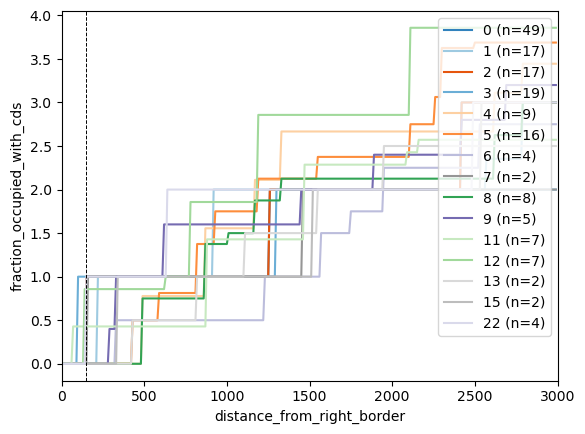

In [286]:
max_length = 3000

# Should check the locations of the first protein-coding genes on each plasmid type. 
variants = [7, 8, 13, 2]
variants = overdrive_df.variant.value_counts().iloc[:15].index # Only plot the 5 most well-represented variants.

cmap = mpl.colormaps.get_cmap('tab20c')
cmap = cmap.resampled(len(variants))
palette = {f:cmap(i) for i, f in enumerate(variants)} # Map each category to a color. 

fig, ax = plt.subplots()
first_cds_df = list()
for variant, df in overdrive_df[overdrive_df.variant.isin(variants)].groupby('variant'):

    orf_positions = None
    figure_df = list()
    for row in df.itertuples():
        path = os.path.join(f'../data/data-1/ncbi/genbank/{row.source_id}.gbk')
        file = GBKFile(path=path)
        if row.strand == '-':
            print(f'Skipping {row.source_id} because I am too lazy to handle reverse strands.')
            continue 
        genbank_df = file.to_df()
        mask = (genbank_df.start > row.start) & (genbank_df.contig_id == row.contig_id) & ((genbank_df.start < row.start + max_length))
        genbank_df = genbank_df[mask].copy()
        genbank_df['start'] = genbank_df.start - row.start # Shift the CDS coordinates. 
        genbank_df['stop'] = genbank_df.stop - row.start # Shift the CDS coordinates. 
        genbank_df['variant'] = variant
        if len(genbank_df) == 0:
            print(f'No proteins found for {path}')
            continue
        first_cds_df.append(genbank_df.sort_values('start', ascending=True).iloc[0])
        figure_df.append(genbank_df)
    figure_df = pd.concat(figure_df)

    # first_cds[variant] = (first_cds_row.start, first_cds_row.stop, first_cds_row.gene, len(first_cds_row.seq))

    x_values = np.arange(0, max_length, 10) # Distance chunks from the right border. 
    y_values = np.array([(figure_df.start < x).sum() for x in x_values])
    y_values = y_values / len(df) # Normalize by the number of strains. 
    # print(f'Plotting {len(x_values)} entropy values.')
    sns.lineplot(x=x_values, y=y_values, label=f'{variant} (n={len(df)})', ax=ax, color=palette[variant])

# ax.set_xlim(xmin=0, xmax=28000)
ax.set_xlim(xmin=0, xmax=max_length)
# ax.set_ylim(ymin=0, ymax=1.1)
ax.legend(loc='upper right')
ax.set_ylabel('fraction_occupied_with_cds')
ax.set_xlabel('distance_from_right_border')
ax.axvline(150, color='black', lw=0.7, ls='--')
plt.show()

first_cds_df = pd.DataFrame(first_cds_df)

In [287]:
max_length = 3000

variants = overdrive_df.variant.value_counts().iloc[:15].index # Only plot the 5 most well-represented variants.

for variant, df in overdrive_df[overdrive_df.variant.isin(variants)].groupby('variant'):
    upstream_region_df = list()
    for row in df.itertuples():
        path = os.path.join(f'../data/data-1/ncbi/genbank/{row.source_id}.gbk')
        file = GBKFile(path=path)
        seq = file.contigs[row.contig_id]
        if row.strand == '-':
            print(f'Skipping {row.source_id} because I am too lazy to handle reverse strands.')
            continue 
        seq = seq[row.start:row.start + min(max_length, len(seq))] # Grab the plasmid sequence starting at the end of the right border. 
        upstream_region_df.append({'source_id':row.source_id, 'seq':seq})
    upstream_region_df = pd.DataFrame(upstream_region_df)

    # data_dir = '/home/prichter/Documents/overdrive/data/data-1'
    if not os.path.exists(f'../data/data-1/variant_{variant}.afn'):
        FASTAFile(df=upstream_region_df.set_index('source_id')).write(f'../data/data-1/variant_{variant}.fn')
        subprocess.run(f'/home/prichter/muscle5.1.linux_intel64 -align ../data/data-1/variant_{variant}.fn -output ../data/data-1/variant_{variant}.afn', shell=True, check=True)

Skipping Atu_B6_ti because I am too lazy to handle reverse strands.
Skipping Atu_B6_ti because I am too lazy to handle reverse strands.


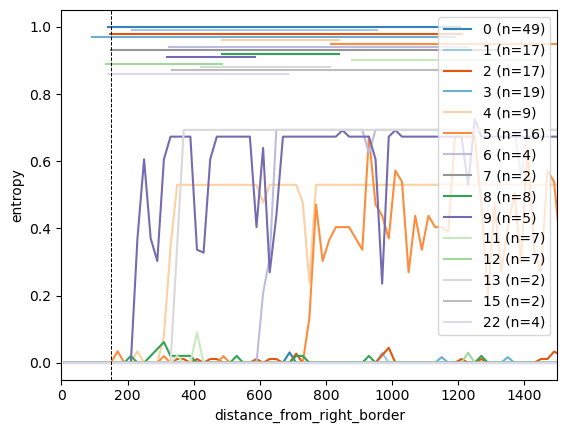

In [ ]:
# Curious about how far the conserved region extends in the plasmids with identical overdrive regions. 
# overdrive_df.value_counts('variant')

# The largest variant group is group 0, with 49 members. 

variants = overdrive_df.variant.value_counts().iloc[:15].index # Only plot the 5 most well-represented variants.



max_length = 3000 

# Should check the locations of the first protein-coding genes on each plasmid type. 
y_shift = 0

fig, ax = plt.subplots()
for variant, df in overdrive_df[overdrive_df.variant.isin(variants)].groupby('variant'):

    _, alignment = load_msa(f'../data/data-1/variant_{variant}.afn')
    positions = np.arange(alignment.shape[-1])
    entropies, _ = get_shannon_entropy(alignment, pad_token=None)
    # assert entropies[:100].sum() == 0, 'Expect the entropies of the first 100 residues to be identical between groups.'

    window_size = 10 
    x_values = list(range(window_size, len(entropies) - window_size, window_size * 2))
    y_values = [np.mean(entropies[i - window_size:i + window_size]) for i in x_values]

    # print(f'Plotting {len(x_values)} entropy values.')
    sns.lineplot(x=x_values, y=y_values, label=f'{variant} (n={len(df)})', ax=ax, color=palette[variant])
    start, stop = first_cds_df[first_cds_df.variant == variant].start.values[0], first_cds_df[first_cds_df.variant == variant].stop.values[0]
    ax.plot([start, stop], [1 + y_shift, 1 + y_shift], color=palette[variant]) #, s=30)
    y_shift -= 0.01

# ax.set_xlim(xmin=0, xmax=28000)
ax.set_xlim(xmin=0, xmax=1500)
ax.legend(loc='upper right')
ax.set_ylabel('entropy')
ax.set_xlabel('distance_from_right_border')
ax.axvline(150, color='black', lw=0.7, ls='--')
plt.show()

In [ ]:
# Strains C58, Ach5, Bo542, A4

# The DNA-binding regions for all three strains are nearly identical. 
overdrive_df = overdrive_df[overdrive_df.strain_id.isin(['C58', 'Bo542', 'Ach5', 'A4'])]

virs_motif = r'[GA]T[TAG][TCA][GAT]T[TC][TC][GA]T'
for row in overdrive_df.itertuples():
    print(row.strain_id, re.findall(virs_motif, row.seq))

# Bo542 and Ach5 have VirC2s with identical DNA binding domains. 
# A4 and C58 have VirC2s with identical DNA binding domains. 

# Ach5 and A4 have identical motifs, despite having VirC2s with different binding domains. 
overdrive_df[['strain_id', 'variant', 'virc1_variant', 'virc2_variant', 'virc2_beta_sheets', 'plasmid_type']]#.drop_duplicates('strain_id')

A4 ['ATAAATTTGT', 'GTATGTTTGT']
Ach5 ['GTATGTTTGT']
Ach5 ['ATTTGTTTGT']
Bo542 ['ATTTGTTTGT']
Bo542 ['ATTTTTTTGT', 'GTTCGTTCGT']
C58 ['GTTTATCCGT']


,strain_id,variant,virc1_variant,virc2_variant,virc2_beta_sheets,plasmid_type
id,,,,,,
A4_12:127426-127526,A4,7,2.0,2.0,PEKIQVFLSARPPA-SIIVQTSRMFPVPL,Type III (Ri)
NZ_CP011249:13177-13277,Ach5,8,0.0,4.0,PKKLQVFLSARPPA-VLVQTSRMFPVALL,Type II (Ti)
NZ_CP011249:22880-22980,Ach5,5,0.0,4.0,PKKLQVFLSARPPA-VLVQTSRMFPVALL,Type II (Ti)
DQ058764:15729-15829,Bo542,13,5.0,8.0,PKKLQVFLSARPPA-VLVQTSRMFPVALL,Type III (Ti)
DQ058764:42315-42415,Bo542,14,5.0,8.0,PKKLQVFLSARPPA-VLVQTSRMFPVALL,Type III (Ti)
AE007871:24834-24934,C58,2,1.0,3.0,PEKIQVFLSARPPA-SIIVQTSRMFPVSL,Type Ia (Ti)


In [295]:
coords = dict()
coords['c58'] = (7002, 7026 + 150)
coords['ach5'] = (7002, 7176) # Plus 150 bp region. 
coords['bo542'] = (7006, 7126)
coords['a4'] = (0, -1)# (7006, 7126)

for strain, (start, stop) in coords.items():
    coords[strain] = (start + 23, stop)

df = list()
for path in glob.glob('../data/*gb'):
    strain = os.path.basename(path).split('_')[-1].replace('.gb', '')
    file = GBKFile(path)
    seq = list(file.contigs.values())[0]
    start, stop = coords[strain]
    motif_positions = [match.start() for match in re.finditer(virs_motif, seq)]
    df.append({'strain_id':strain, 'seq':seq[start:stop], 'full_seq':seq, 'start':start, 'stop':stop, 'motif_positions':motif_positions})
df = pd.DataFrame(df).set_index('strain_id')

df.loc['a4', 'seq'] = 'TGACAGGATATATCTTGTGGTCAGGTAGATAAATTTGTGTGGAGGTATGTTTGTTTAGGACGGCGGTGATGATGGCTTGCGCCTTACGTCCCGAAAGCAGTCCACGAAGACAATTGCAATATCGG'
df.loc['a4', 'start'] = re.search(df.loc['a4', 'seq'], df.loc['a4', 'full_seq']).start()
df.loc['a4', 'stop'] = re.search(df.loc['a4', 'seq'], df.loc['a4', 'full_seq']).end()

df['seq'] = df.seq.str.slice(0, 100)
df['variant'] = df.seq.map(overdrive_df.drop_duplicates('variant').set_index('seq').variant)

In [296]:
df

,seq,full_seq,start,stop,motif_positions,variant
strain_id,,,,,,
bo542,TTTTGTACGTCTCTCATGAGATAAGAGCATTTGATTGTTGATTTGT...,ATATGCGGTGTGAAATACCGCACAGATGCGTAAGGAGAAAATACCG...,7029,7126,"[235, 777, 2087, 3948, 4304, 5670, 6565, 6870,...",NaN
c58,CCTAAGAGAAAAGAGCGTTTATTAGAATAATCGGATATTTAAAAGG...,ATATGCGGTGTGAAATACCGCACAGATGCGTAAGGAGAAAATACCG...,7025,7176,"[235, 777, 2087, 3948, 4304, 5670, 6565, 6870,...",NaN
a4,TGACAGGATATATCTTGTGGTCAGGTAGATAAATTTGTGTGGAGGT...,ATATGCGGTGTGAAATACCGCACAGATGCGTAAGGAGAAAATACCG...,7005,7130,"[235, 777, 2087, 3948, 4304, 5670, 6565, 6870,...",NaN
ach5,TTGAGCTCGTGTGAATAAGTCGCTGTGTATGTTTGTTTGATTGTTT...,ATATGCGGTGTGAAATACCGCACAGATGCGTAAGGAGAAAATACCG...,7025,7176,"[235, 777, 2087, 3948, 4304, 5670, 6565, 6870,...",NaN


In [297]:
overdrive_df

,seq,right_border_seq,left_of_right_border_seq,left_of_right_border_start,left_of_right_border_stop,start,stop,strand,source_id,contig_id,...,biovar,genomospecies,plasmid_type,plasmid_class,variant,virc1_seq,virc2_seq,virc2_beta_sheets,virc1_variant,virc2_variant
id,,,,,,,,,,,,,,,,,,,,,
A4_12:127426-127526,GGTAGATAAATTTGTGTGGAGGTATGTTTGTTTAGGACGGCGGTGA...,TGACAGGATATATCTTGTGGTCA,CGGCTCTTTCACATGAGCGAGCTGACACATAGTTTGGACGCCAGTT...,127303,127403,127426,127526,+,A4_ri,A4_12,...,BV2,none,Type III (Ri),Ri,7,MKLLTFCSFKGGAGKTTALMGLCAALASDGRRVALFDADENRPLTR...,MGIRKPALSVGEARRLAAARPEMVQAHLPVATQNSALPQPPENPDQ...,PEKIQVFLSARPPA-SIIVQTSRMFPVPL,2.0,2.0
NZ_CP011249:13177-13277,TTTGAGCTCGTGTGAATAAGTCGCTGTGTATGTTTGTTTGATTGTT...,TGGCAGGATATATACCGTTGTAA,AATATTGTACGGCTAAGAGCGAATTTGGCCTGTAGACCTCAATTGC...,13054,13154,13177,13277,+,Ach5_ti,NZ_CP011249,...,BV1,G1,Type II (Ti),Ti,8,MQLLTFCSFKGGAGKTTALMGLCAALANDGKRVALFDADENRPLTR...,MAIRKPALSVSEARRLAVARSEIHHPNPTLVPQELDLQHLPEKADE...,PKKLQVFLSARPPA-VLVQTSRMFPVALL,0.0,4.0
NZ_CP011249:22880-22980,TTCATTTTTATTGTCTAAATTTCTGTATTTGTTTGTTTGTTCGGTT...,TGGCAGGATATATGCGGTTGTAA,CCGCGATTTCTTTATCGTGTAGACAATCAACCGACTTAAAATTATC...,22757,22857,22880,22980,+,Ach5_ti,NZ_CP011249,...,BV1,G1,Type II (Ti),Ti,5,MQLLTFCSFKGGAGKTTALMGLCAALANDGKRVALFDADENRPLTR...,MAIRKPALSVSEARRLAVARSEIHHPNPTLVPQELDLQHLPEKADE...,PKKLQVFLSARPPA-VLVQTSRMFPVALL,0.0,4.0
DQ058764:15729-15829,ATTTTGTACGTCTCTCATGAGATAAGAGCATTTGATTGTTGATTTG...,TGGCAGGATATATTGGGGTGTCA,TTGTATTAGCGCATAAGCATCACATTGATTTTTGAAGCAGAGCGTC...,15606,15706,15729,15829,+,Bo542_ti,DQ058764,...,BV1,G1,Type III (Ti),Ti,13,MQLLTFCSFKGGAGKTTALMGLCAALANDGKRVALFDADENRPLTR...,MAIRKPALSVGEARRLAGARPEIHHPNPTLVPQKLDLQHLPEKADE...,PKKLQVFLSARPPA-VLVQTSRMFPVALL,5.0,8.0
DQ058764:42315-42415,TTCATTTCTACCGTGTAATTTACTGTATTTTTTTGTTTGTTCGTTC...,TGGCAGGATATATGTGGTTGTAA,TCGCGATTTCTTTATCGTGTAGATAGTCAATCGACTTAAAATTATC...,42192,42292,42315,42415,+,Bo542_ti,DQ058764,...,BV1,G1,Type III (Ti),Ti,14,MQLLTFCSFKGGAGKTTALMGLCAALANDGKRVALFDADENRPLTR...,MAIRKPALSVGEARRLAGARPEIHHPNPTLVPQKLDLQHLPEKADE...,PKKLQVFLSARPPA-VLVQTSRMFPVALL,5.0,8.0
AE007871:24834-24934,ACCTAAGAGAAAAGAGCGTTTATTAGAATAATCGGATATTTAAAAG...,TGACAGGATATATTGGCGGGTAA,CTTGTCCCGCGTCATCGGCGGGGGTCATAACGTGACTCCCTTAATT...,24711,24811,24834,24934,+,C58_ti,AE007871,...,BV1,G8_a,Type Ia (Ti),Ti,2,MKLLTFCSFKGGAGKTTALMGLCAAFASDGKRLALFDADENRPLTR...,MGIRKPALSVGEARRLAAARPEIVHPSLPVATQNSTLPQPPENLDE...,PEKIQVFLSARPPA-SIIVQTSRMFPVSL,1.0,3.0


In [122]:
virs_motif = r'[GA]T[TAG][TCA][GAT]T[TC][TC][GA]T'

for row in df.itertuples():
    for match in re.finditer(virs_motif, row.seq):
        print(row.Index, match.span(), match.group(0))

# Native Bo542, C58, and Ach5 overdrive do 20% better with native vir genes than in the non-native strain.
# A4 results are inconclusive, but it seems as though C58 overdrive did better than A4 overdrive in A4. 

JL5275_13:10101-10201 (33, 43) GTATGTTTGT
JL5275_13:10101-10201 (68, 78) GTTCGTTTGT
JL5280_13:49485-49585 (33, 43) GTATGTTTGT
JL5280_13:49485-49585 (68, 78) GTTCGTTTGT
JL5286_8:161175-161275 (33, 43) GTATGTTTGT
JL5286_8:161175-161275 (68, 78) GTTCGTTTGT
AS1E5_15:10101-10201 (33, 43) GTATGTTTGT
AS1E5_15:10101-10201 (68, 78) GTTCGTTTGT
AS1F5_16:10101-10201 (33, 43) GTATGTTTGT
AS1F5_16:10101-10201 (68, 78) GTTCGTTTGT
AS1H5_7:10002-10102 (33, 43) GTATGTTTGT
AS1H5_7:10002-10102 (68, 78) GTTCGTTTGT
AS1I5_10:10002-10102 (33, 43) GTATGTTTGT
AS1I5_10:10002-10102 (68, 78) GTTCGTTTGT
AS2H7_11:92902-93002 (33, 43) GTATGTTTGT
AS2H7_11:92902-93002 (68, 78) GTTCGTTTGT
AS2I7_11:92902-93002 (33, 43) GTATGTTTGT
AS2I7_11:92902-93002 (68, 78) GTTCGTTTGT
AS2B7_15:10101-10201 (33, 43) GTATGTTTGT
AS2B7_15:10101-10201 (68, 78) GTTCGTTTGT
JL5226_10:27870-27970 (33, 43) GTATGTTTGT
JL5226_10:27870-27970 (68, 78) GTTCGTTTGT
JL5281_11:45941-46041 (33, 43) GTATGTTTGT
JL5281_11:45941-46041 (68, 78) GTTCGTTTGT
AS2E1_

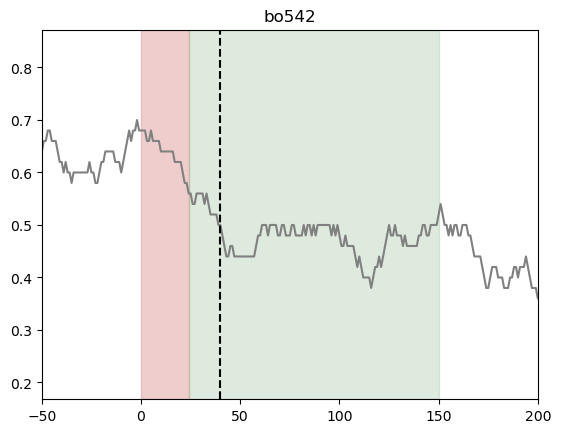

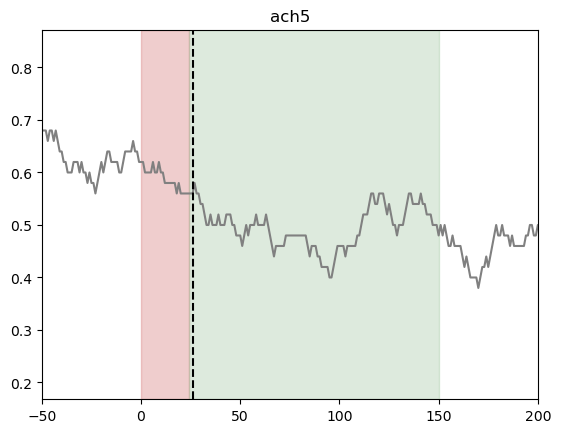

In [97]:
def get_at_content(seq:str, window_size:int=25):

    windows = [seq[i - window_size:i  + window_size] for i in range(window_size, len(seq) - window_size)]
    at_content = np.array([window.count('A') + window.count('T') for window in windows])
    at_content = at_content / (window_size * 2)
    return at_content

strain = 'c58'

# fig, ax = plt.subplots()
# for strain in df.index:
for strain in ['bo542', 'ach5']:
    rb_length = 24 

    fig, ax = plt.subplots()
    start, stop = df.loc[strain, 'start'], df.loc[strain, 'stop']
    at_content = get_at_content(df.loc[strain, 'full_seq'])
    position = np.arange(len(at_content)) - start
    sns.lineplot(x=position, y=at_content, color='gray')

    for motif_position in df.loc[strain, 'motif_positions']:
        ax.axvline(motif_position - start, color='black', ls='--')

    ax.axvspan(xmin=0, xmax=rb_length, color='indianred', alpha=0.3)
    ax.axvspan(xmin=rb_length, xmax=150, color='darkseagreen', alpha=0.3)

    delta = 200
    ax.set_xlim(xmin=-50, xmax=delta)
    ax.set_title(strain)
plt.show()